# Gym chain customers churn forecasting

This project depicts the situation, where the gym chain Model Fitness is developing a customer interaction strategy based on analytical data. In order to fight churn, Model Fitness has digitized a number of its customer profiles.

One of the most common problems gyms and other services face is customer churn. In order to fight it, Model Fitness has digitized a number of its customer profiles. The task is to analyze them and come up with a customer retention strategy.

2 machine learning approaches will be used: supervised binary classification (**Logistic regression** and **Random forest** algorythms) and unsupervised clusterization (**K-means** algorythm). 

**Description of the data**
* `Churn` — the fact of churn for the month in question

User data for the preceding month:
* `gender`
* `Near_Location`— whether the user lives or works in the neighborhood where the gym is located
* `Partner`— whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
* `Promo_friends` — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
* `Phone` — whether the user provided their phone number
* `Age`
* `Lifetime` — the time (in months) since the customer first came to the gym

Data from the log of visits and purchases and data on current membership status:
* `Contract_period` — 1 month, 3 months, 6 months, or 1 year
* `Month_to_end_contract` — the months remaining until the contract expires
* `Group_visits`— whether the user takes part in group sessions
* `Avg_class_frequency_total` — average frequency of visits per week over the customer's lifetime
* `Avg_class_frequency_current_month`— average frequency of visits per week over the preceding month
* `Avg_additional_charges_total`— the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

# Table of contents

* [**Exploratory data analysis**](#1)
 * [Total sample values overview](#2) 
 * [Overview of the sample, divided into the groups](#3)
 * [Features visualization](#4)
* [**Data preprocessing**](#5)
 * [Data regularization](#5)
 * [Data splitting into X (independent variables) and y (dependent variable)](#6) 
 * [Dividing data into train and validation sets](#7) 
 * [Data Standardization](#8) 
* [**Building models for customer churn prediction**](#9) 
 * [Logistic regression](#9) 
 * [Random forest](#10)
 * [Conclusion](#11)
* [**Custumers clusterization**](#12)
 * [Data standardization](#12)
 * [Distance matrix calculation and Dendrogram plotting](#13)
 * [K-means clustering algorithm](#14)
   * [Dataset without multicollinear columns](#14)
   * [Dataset with feature engineering](#15)
* [**Conclusion**](#16)
* [**Recommendations**](#17)


# Initialization

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time

<a id="1"></a> 
## Exploratory data analysis

In [3]:
df = pd.read_csv('C:/Users/ADMIN/Downloads/gym_churn_us.csv')

In [4]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
df.duplicated().sum()

0

In [6]:
df.Churn.value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

Dataset consists of 4000 individuals, no missing or apparently duplicated values are found. It contains information on 2939 customers, who continue going to the gym and 1061 customer, who quitted.
<a id="2"></a> 
### Total sample values overview

In [7]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Data overview:**
* Gender: nearly equal counts of people of both genders are present in the dataset
* 85% of logged customers are living or working near the gym
* 47% of them have come by the Partner program
* 31% of customers signed up through a "bring a friend" offer
* 90% of them provided their phone number
* Mean contract period is 4.7 months with a std of 4.5
* 41% of users took part in group sessions
* Mean customer's age is 29 years, with a std of 3.25
* On average each person spends 147 dollars with std of 96 dollars on additional services 
* Mean number of months till the contract's end is 4 with a std of 4 - sample is highly non-homogenic 
* Average number of months since the customer first came to the gym is 3.7 with std of 3.7 (highly non-homogenic)
* Average frequency of visits per week over the customer's lifetime is 1.9, with std of 1 (highly non-homogenic)
* Average frequency of visits per week over the preceding month is 1.8 with std of 1 (highly non-homogenic)
* 26% of customers quitted in the question month

<a id="3"></a> 
### Overview of the sample, divided into the groups
Sample will be divided on customers, who has quitted going to the gym (`Churn` = 1) and those, who continue (`Churn` = 0)

In [8]:
df.groupby('Churn').mean().T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


**Differential overview:**

*Values, which differs between groups are written in* **bold** *font style*.
* Gender distributions are equal in both groups
* **The fact of living or working near the gym affect the possibility of leaving the gym weackly, as mean values are quite close in both groups (difference is about 10%)**
* **Customers of 'Partner' programm tend to continue going to the gym more, that those, who don't have such a programm (difference is approx 20%)**
* **Customers from "Bring a friend" programm tend to continue going to the gym more, that those, who don't have such a programm (difference is approx 20%)**
* No differences on share of people, who has provided their phone, was found between groups
* **Those who quitted the gym show strong tendency to buy a long-term contracts, while those, who quitted it, prefer short contracts**
* **Customers, attending group sessions shows better probability to continue going to gym, than those, who prefer solo workouts**
* **Those customers, who left, tend to be younger, than those, who continue**
* **Those, who continue to go to the gym tends to spend more on additional services**
* **People, who quitted the gym are likely to do it in approx 1.7 months before their contract ends, while those, who still attend it tend to have 5.3 months before their contract ends**
* **Those, who stops going to gym tend to do it in 1 month after they firstly have come, while average lifetime of those, who still goes there is 4.7 months**
* **Customers, who didn't quit their exercises in the gym tend to come twice a week, while customers, who quitted had came from 1 to 2 (1.5 on average) times a week**
* **Over the preceding month weekly number of visits of those, who continue to come, is 2, and those, who stopped is 1.**

Seems like features `Gender` and `Phone` do not have impact on probability of customers to continue or quit the gym, so they can be dropped in further analysis. Other features may indeed affect the probability of customer's churn.

<a id="4"></a> 
### Features visualization

In [9]:
binary_cols = []
for col in df.columns:
    if str(df[col].unique()) == '[1 0]' or str(df[col].unique()) == '[0 1]':
        binary_cols.append(col)
contineous_cols = [x for x in df.columns if x not in binary_cols]
binary_cols = binary_cols[:-1]

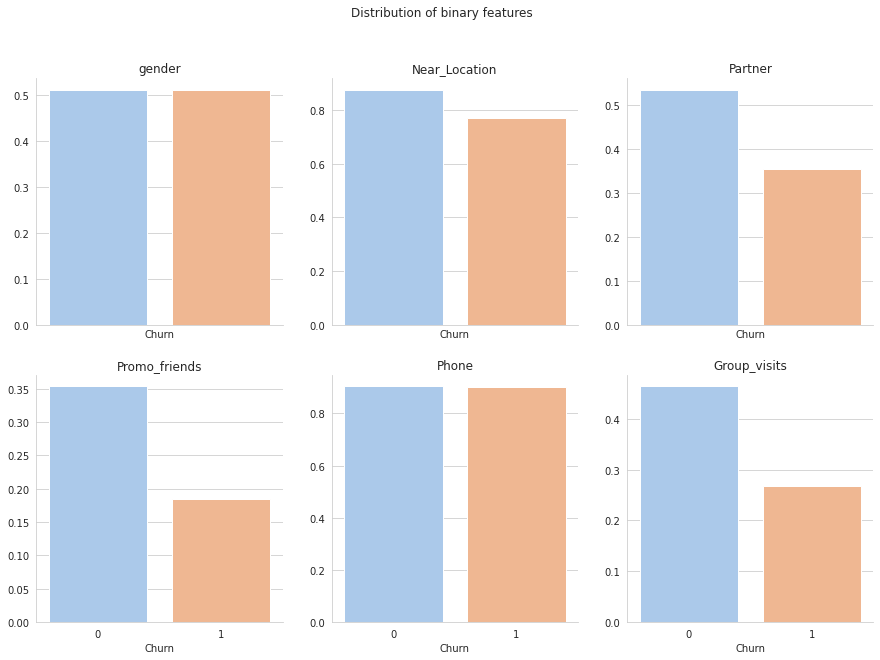

In [10]:
with sns.axes_style("whitegrid"): 
    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
    k=0
    for i in range(2):
        for j in range(3):
            figure.suptitle('Distribution of binary features')
            axes[i,j].set_title(binary_cols[k])
            sns.despine()
            sns.barplot(ax=axes[i,j], data = df, x = 'Churn', y = binary_cols[k], ci=None, palette = 'pastel').set(ylabel=None)
            k+=1

**Binary features:**

Customers who are prone to churn show less tendency to:
* `Live of work near`
* Come through `Partner` programm
* Come through `Promo_friends` programm
* Attend `Group` sessions

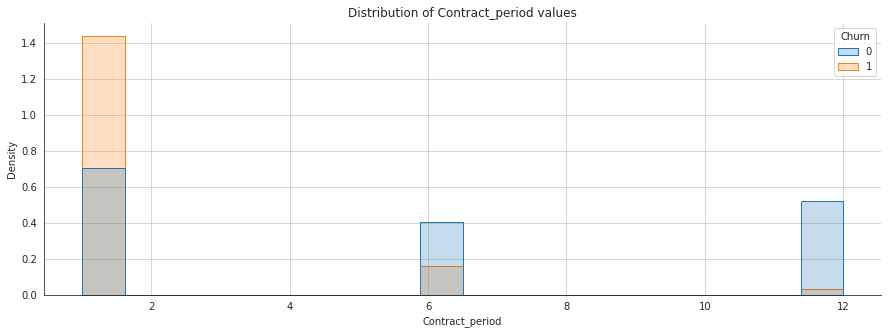

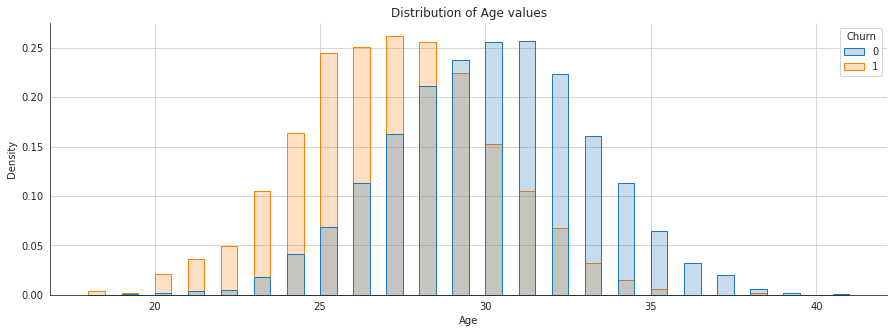

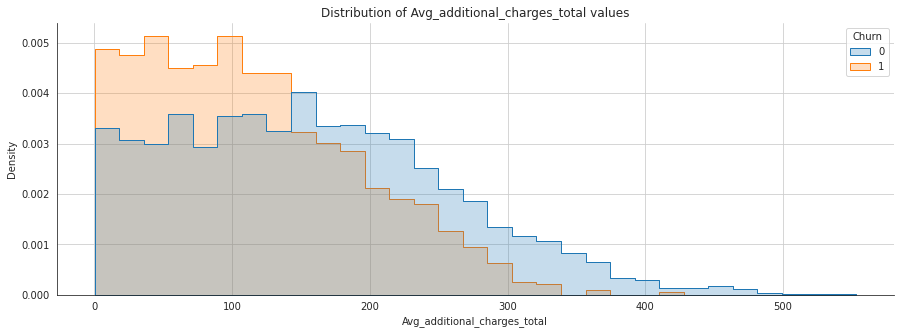

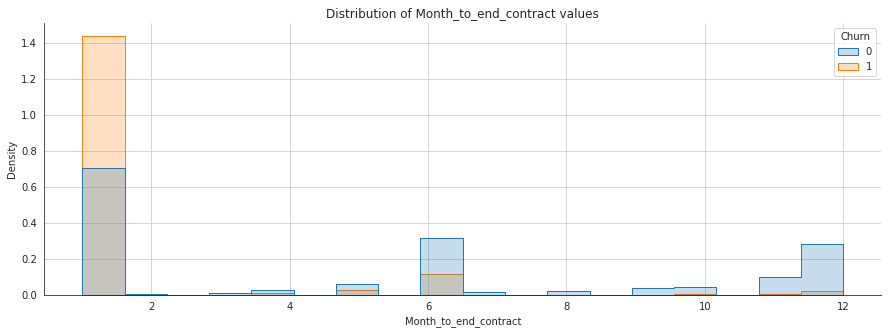

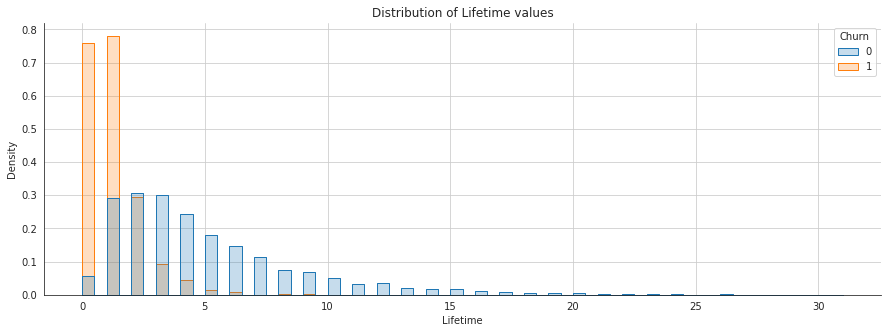

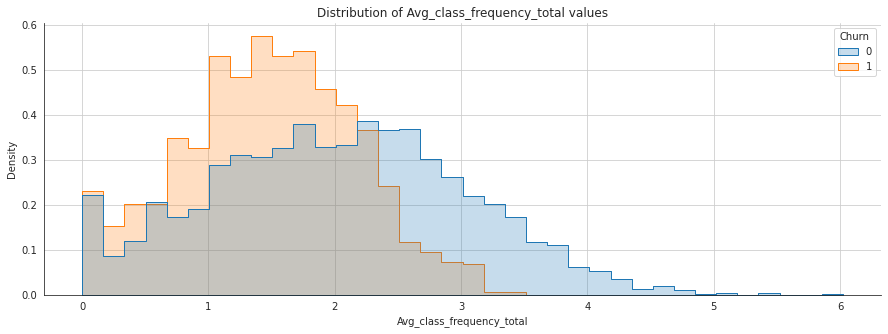

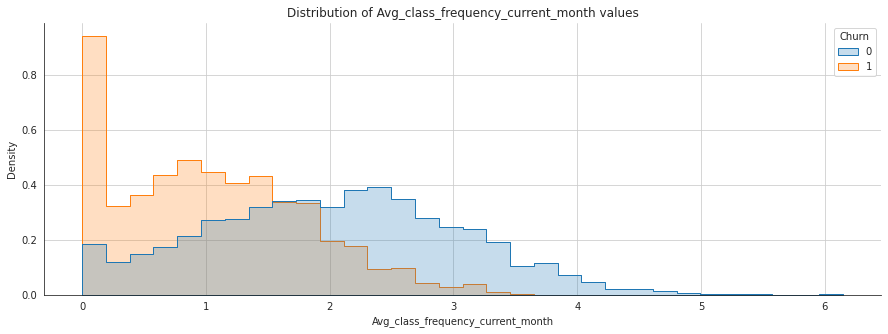

In [11]:
for col in contineous_cols:
        sns.set_style("white")
        plt.figure(figsize = (15,5))
        sns.histplot(data = df, x = col, hue = 'Churn', stat = 'density', common_norm = False, element="step")
        sns.despine()
        plt.grid()
        plt.title(f'Distribution of {col} values')
        plt.show()

**Contineous features:**
* **Age:** distributions in both groups are normal, customers, who continue going to gym, are tend to be a bit older, then those, who continue
* **Average additional charges:** both distributions are heavily right-skewed. Those, who continue attending the gym have longer right tail with a less pronounced peak near 150 dollars. quitted customers has more condenced values in range of 0-100 dollars
* **Lifetime:** those, who stopped gym are nearly never have gone there longer, than 5 months (Most of them have attended 1-2 months only). Typical lifetime of those, who continue is 1-7 months with a long tail to the right
* **Average class freauency total:** both distributions are more or less normal, but churn ones have a huge peak in range of 1-2 classes a week. Continuing customers show more homohenic plato of 1-3 classes a week and a long tail to the right up to maximum of 6.
* **Average frequency current month:** customers, who left the gym show a huge peak in 0 classes a week in the last logged month and a peak a bit less than 1. Continuing customers show more homogenic distribution, with the largest number of those, who attend gym 1-2 times a week.

In consideration of customer retention, it is my belief that individuals who are currently categorized as non-quitters and have not attended any weekly classes are likely to terminate their engagement in the future. This distinct characteristic holds potential significance for the purpose of predictive modeling.

<a id="corr"></a> 

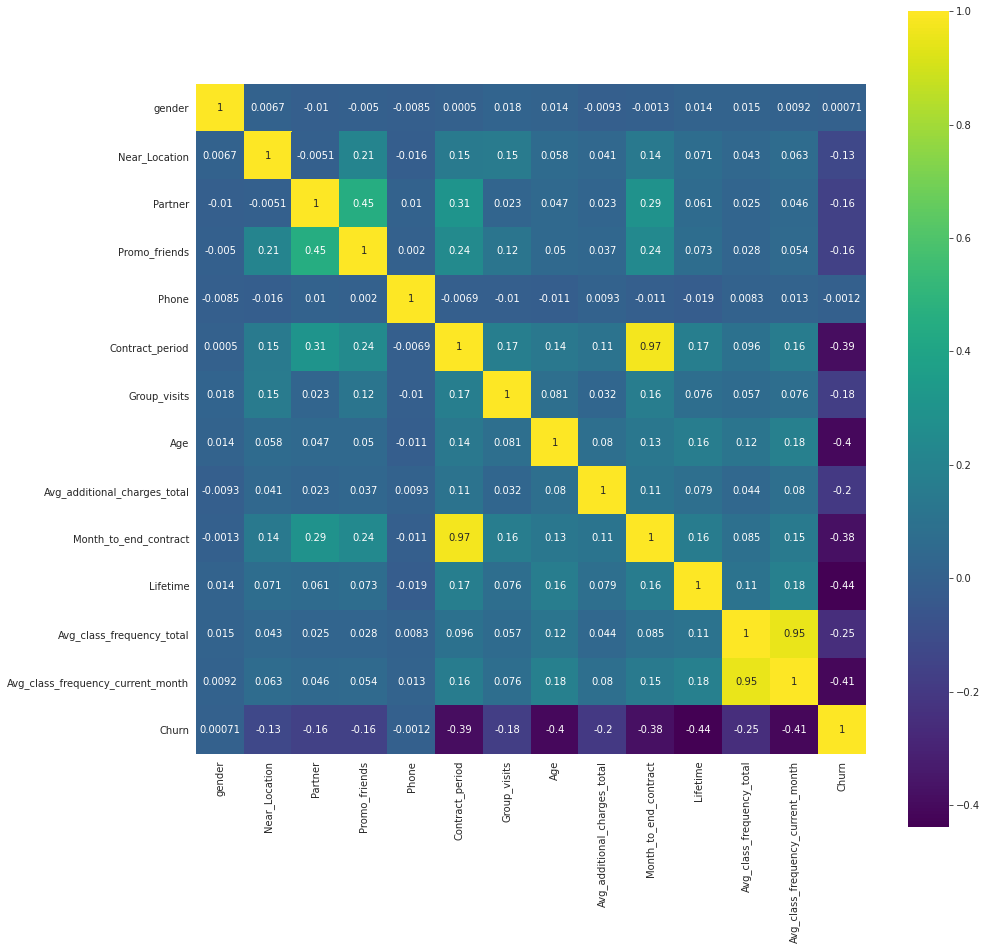

In [12]:
correlation = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(correlation, square = True,annot = True, cmap="viridis")
plt.show()

**The most correlating with `Churn` features are:**
* `Avg_class_frequency_current_month`, coeff = -0.41 
* `Lifetime`, coeff = -0.44
* `Month_to_end_contract`, coeff = -0.38
* `Age`, coeff = -0.4
* `Contract_period`, coeff = -0.39

Those features will be potentionally the most important for forecasting.

**Multicollinear features are:**
* `Avg_class_frequency_total` and `Avg_class_frequency_current_month`, coeff 0.95
* `Month_to_end_contract` and `Contract_period`, coeff 0.97

Those features may be dropped before the machine learning procedures in order to prevent their sinergic effect on the results. Also L1/L2 regularization approaches may be used.

**Noticeably intercorrelated independed features are:**
* `Partner` and `Promo_friends`, coef 0.45

**Conclusion**

`Gender` and `Phone` features have exactly equal shares in both studied groups, so they should't have any effect on the results of machine learning procedure.

Multicollinear pairs of features `Avg_class_frequency_total`-`Avg_class_frequency_current_month` and `Month_to_end_contract`-`Contract_period` will need to have special attention.

<a id="5"></a> 
## Data preprocessing
### Data regularization

As **logistic regression** and **random forest** approaches will be used, multicollinear features should be dropped. 
* From the pair `Month_to_end_contract` and `Contract_period` I will drop the `Month_to_end_contract` feature, because it has slightly weaker correlation with the target feature `Churn`.
* From the pair `Avg_class_frequency_total` and `Avg_class_frequency_current_month` I will drop the `Avg_class_frequency_total` feature, as it has significantly weaker correlation with the target feature `Churn`. And it says a bit more about the recent customer's gym attendance.

In [13]:
df_preprocessed = df.drop(['Month_to_end_contract','Avg_class_frequency_total'], axis = 1)
df_preprocessed.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


<a id="prep"></a> <a id="6"></a>  
### Data splitting into X (independent variables) and y (dependent variable)

In [14]:
X = df_preprocessed.drop('Churn', axis = 1)
y = df_preprocessed.Churn

<a id="7"></a> 
### Dividing data into train and validation sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<a id="8"></a> 
### Data Standardization

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Now everything is ready for a machine learning.

<a id="9"></a> 
## Building models for customer churn prediction
### Logistic regression

In [17]:
model = LogisticRegression(random_state=42)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

In [18]:
print(model)
print('Accuracy:', round(accuracy_score(y_test, predictions),2))
print('Precision:', round(precision_score(y_test, predictions),2))
print('Recall:', round(recall_score(y_test, predictions),2))

LogisticRegression(random_state=42)
Accuracy: 0.9
Precision: 0.79
Recall: 0.82


In [19]:
percentile_list = pd.DataFrame({'Feature': X_train.columns,
     'Weight': model.coef_[0]})
percentile_list

,Feature,Weight
0,gender,0.050670
1,Near_Location,-0.083076
2,Partner,-0.069225
3,Promo_friends,-0.244437
4,Phone,-0.088119
5,Contract_period,-1.340862
6,Group_visits,-0.378909
7,Age,-1.102478
8,Avg_additional_charges_total,-0.582020
9,Lifetime,-3.922703


Quite good results are observed for the Logistic Regression algorythm. Also, It is well seen, that the weights assigned to the features are in good consistency with their correlation with the target feature. The most important ones are: `Avg_class_frequency_current_month`, `Lifetime` (the biggest weight overall), `Age` and a `Contract_period`.

<a id="10"></a> 
### Random forest

In [20]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

In [21]:
print(model)
print('Accuracy:', round(accuracy_score(y_test, predictions),2))
print('Precision:', round(precision_score(y_test, predictions),2))
print('Recall:', round(recall_score(y_test, predictions),2))

RandomForestClassifier(random_state=42)
Accuracy: 0.9
Precision: 0.83
Recall: 0.77


In [22]:
percentile_list = pd.DataFrame({'Feature': X_train.columns,
     'Weight': model.feature_importances_[0]})
percentile_list

,Feature,Weight
0,gender,0.016537
1,Near_Location,0.016537
2,Partner,0.016537
3,Promo_friends,0.016537
4,Phone,0.016537
5,Contract_period,0.016537
6,Group_visits,0.016537
7,Age,0.016537
8,Avg_additional_charges_total,0.016537
9,Lifetime,0.016537


The results are good with the RandomForest classifier, but an interesting thing can be observed here: all features show the same importance. This may be or may be not a sign of some issues with the dataset or a model. Althoug, until the results of it's forecasting are good, it may not be a cause for concern.

<a id="11"></a> 
### Conclusion

Overall *accuracy* of both models is equal to 0.9, on average both of them predict the user churn quite well. The differences are observed in *precision* and *recall* metrics. 

* **Logistic Regression** has a precision score of 0.79, which means that out of all the positive predictions it made, only 79% were actually correct. Meanwhile, its recall score of 0.82 indicates that it correctly identified 82% of all actual positive instances.
* **Random Forest** Classifier has a higher precision score of 0.83, suggesting that it made more accurate positive predictions. However, its lower recall score of 0.77 means that it missed identifying some actual positive instances.

If correctly identifying as many positive instances as possible is crucial, then **Logistic Regression** might be the better choice due to its higher recall score. However, if minimizing false positives is more important, then **Random Forest Classifier's** higher precision score may be more desirable.

For this specific situation the better choice seems to be a **Logistic Regression**, as it is worse to lose a paying customer than to give some small bonus to a customer who wasn't going to leave.

<a id="12"></a> 
## Custumers clusterization
### Data standardization

Here I will use the already created subset `X` from the [preprocessing step](#prep), as it doesn't have multicollinear features and contains only the independent variables.

In [23]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

<a id="13"></a> 
### Distance matrix calculation and Dendrogram plotting

In [24]:
linked = linkage(X_sc, method = 'ward') 

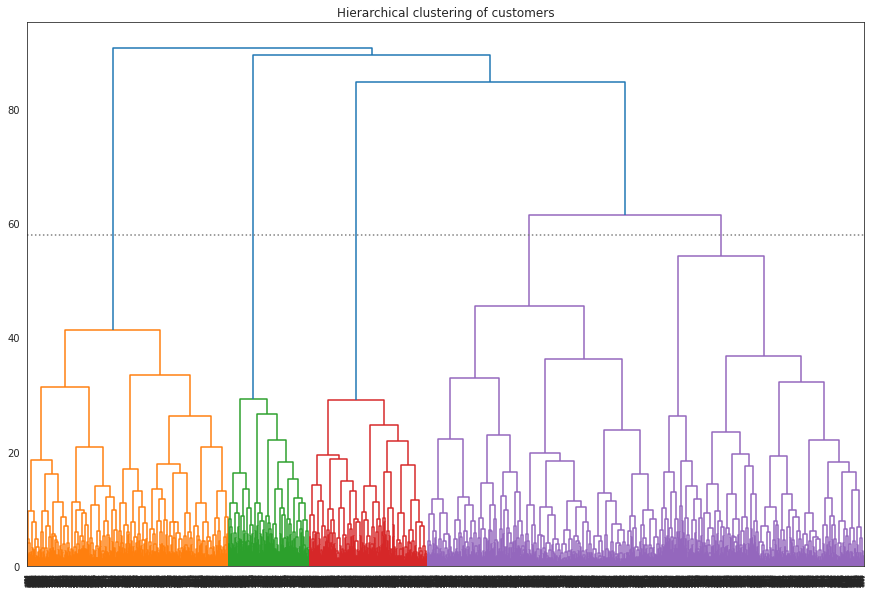

Elapsed time: 124.04 seconds


In [25]:
start_time = time.time()

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering of customers')
plt.axhline(y = 58, linestyle = ':', color = 'gray')
plt.show() 

end_time = time.time()

elapsed_time = end_time - start_time

print("Elapsed time: {:.2f} seconds".format(elapsed_time))

4 major and distant clusters are found (shown in different colors on the dendrogram). However the biggest cluster on the right can be divided into 2 very pronounced smaller clusters. They still won't be ideally homogenic, but lowering the threshold of the distance for clusters division more will quickly lead to creating an excessive number of them, making it harder and harder to analyze.

<a id="14"></a> 
### K-means clustering algorithm
* **Dataset without multicollinear columns**

Let the number of clusters be n=5.

In [26]:
km = KMeans(n_clusters = 5, random_state=42)
labels = km.fit_predict(X_sc)
df['cluster'] = labels

In [27]:
df['cluster'].value_counts()

2    1361
1     958
4     735
0     560
3     386
Name: cluster, dtype: int64

Clusters have unequal size.

In [28]:
round(silhouette_score(X_sc, labels),4)

0.1315

The silhouette score is not too optimistic, but 0.13 is better than random.

In [29]:
df.groupby(['cluster']).mean().sort_values(by = 'Churn')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
1,0.506263,0.993737,0.840292,0.625261,1.0,9.886221,0.630480,30.332985,174.669326,8.918580,5.475992,2.243043,2.247335,0.007307
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
2,0.528288,1.000000,0.000000,0.055107,1.0,2.736958,0.405584,29.032329,142.722846,2.597355,3.288024,1.839897,1.705114,0.332109
4,0.484354,1.000000,0.934694,0.541497,1.0,2.715646,0.268027,28.278912,127.237836,2.582313,2.674830,1.574446,1.404365,0.372789
0,0.498214,0.000000,0.487500,0.078571,1.0,3.016071,0.233929,28.698214,137.520958,2.839286,3.019643,1.768217,1.601681,0.401786


In terms of **Churn rate** this round of Machine learning have found 1 super-loyal cluster with churn rate of 0.007 (cluster 1). This group of customers consists mostly of customers, who:
* Live or work `near`(99%, which is not very different from other clusters except for 1)
* 84% of them have come by a `Partner programm`
* 63% by a `Promo_friends`programm (the highest value among all clusters)
* all of them have provided their `Phone` number
* have the longest `Contract_period`(9.9 months)
* Have the biggest share of people attending `Group_visits` (63%)
* Have the highest average `Age`(30.3 years)
* Spend biggest amount of money on `Additional charges` (174.7 dollars avg)
* Have the `longest time until the end of contract` (8.9 months)
* Have already attended the gym` longer`, then others (5.48 months)
* And have the best `attendance` among other clusters (2.24 `total weekly` and 2.25 `weekly in the current month`)

On the other hand, cluster 0 has a biggest churn rate of 0.4:
* 100% of customers **don't** live `near` to gym (the most pronounced difference from other clusters)
* 49% of them came by `Partner programm`
* 8% of them came by `Promo_friends` programm
* All of them have provided their `Phone` number
* They prefer nearly exclusively the 3-month `Contract period`
* Customers from this cluster have the least number of those, who attend the `Group_visits` (23%)
* Their average `Age` is 28.7 years
* They spend 137.5 dollars on `Additional charges` on average
* They have 2.8 months until `Contract end` on average
* Their average `Lifetime` is 3 months
* They attend gym 1.8 times a week in `total` and 1.6 times a week in the `current month`.

What is interesting, that cluster 4 has nearly same churn rate of 0.37, but in opposite to cluster 0 in:
* Only those customers, who live or work `near` the gym
* 93% of customers came through `Partner` programm (vs 49% in cluster 0)

And a bunch of extremum features values:
* The smallest `Contract_period` among other clusters (2.7 months)
* The youngest `Age` - 28.3 years
* They spend least amount of money on `Additional charges` - 127 dollars
* The least time until the `Contract end` - 2.6 months
* The least `Lifetime` of 2.7 months
* And the smallest `Attendance frequency` (1.6 `total weekly` and 1.4 `weekly in a current month`)

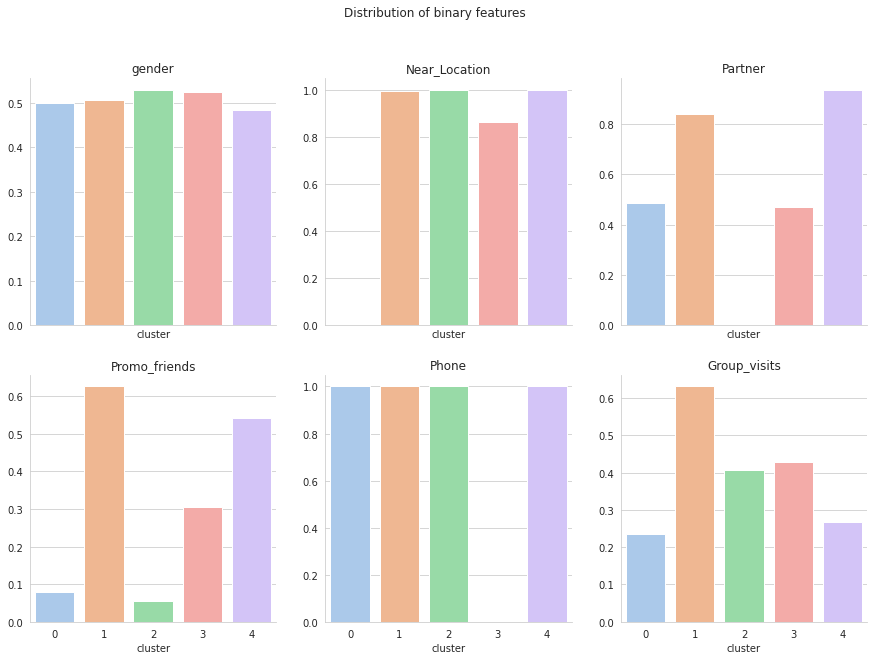

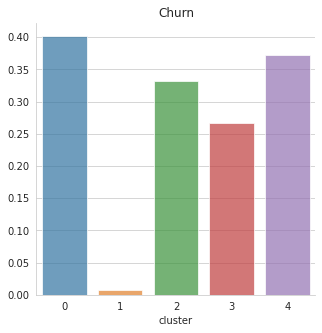

In [30]:
with sns.axes_style("whitegrid"): 
    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
    k=0
    for i in range(2):
        for j in range(3):
            figure.suptitle('Distribution of binary features')
            axes[i,j].set_title(binary_cols[k])
            sns.despine()
            sns.barplot(ax=axes[i,j], data = df, x = 'cluster', y = binary_cols[k], palette = 'pastel', ci=None).set(ylabel=None)
            k+=1
    plt.figure(figsize = (5,5))
    plt.title('Churn')
    sns.barplot(data = df, x = 'cluster', y = 'Churn', alpha = .7, ci=None).set(ylabel=None)
    sns.despine()
    plt.show()

**Noticiable detailes of binary features distributions of clusters:**
* Genders are distributed identically in all clusters
* Cluster 0 consists only of customers, who **don't** `live or work near` the gym
* `Partner` feature divides clusters into 3 groups: where customers has come nearly exclusively from this programm (clusters 1 and 4), where there is a half of such customers (0 and 3) and exclusivelly not from this programm (cluster 2)
* `Promo friends`: clusters 0 and 2 have less, than 10% of custemers from this programm, cluster 3 has 30% of them and clusters 1 and 4 have more, than 50% of them
* `Phone`: in cluster 3 nobody provided their phone numbers, in other clusters 100% of customers have provided it
* `Group visits`: cluster 1 shows the biggest percentage of customers, who attend grouped classes (more, than 60%), other have less shares of such customers
* `Churn`: cluster 1 consists of super-loyal customers (churn rate is less, than 1%), other clusters show from 25% to 40% of quitted customers.

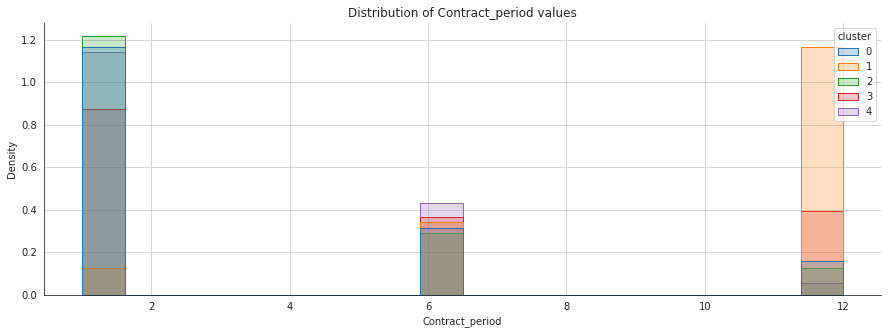

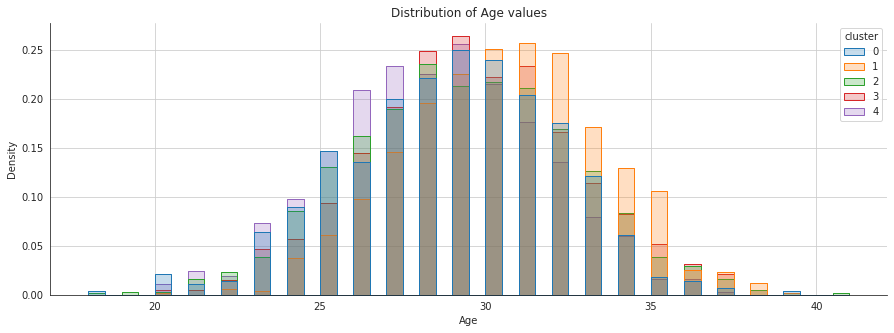

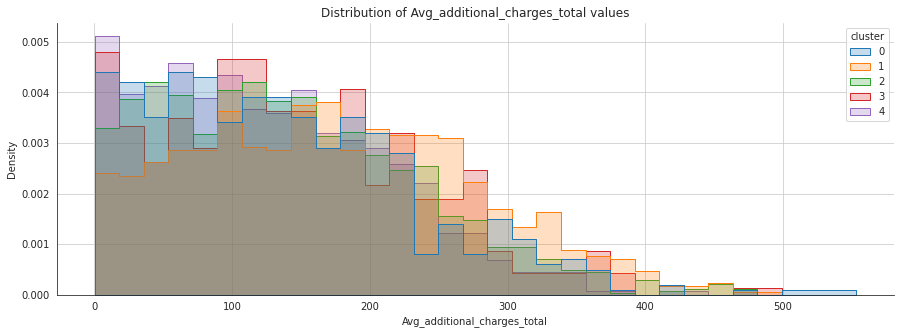

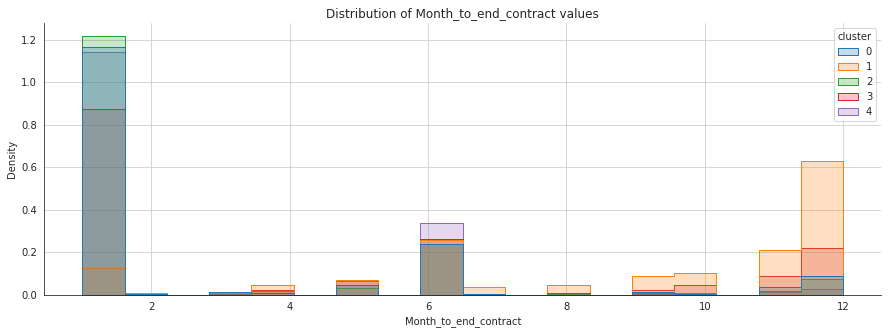

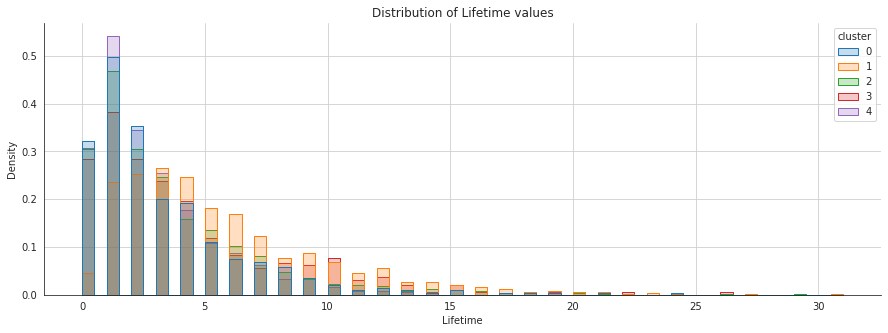

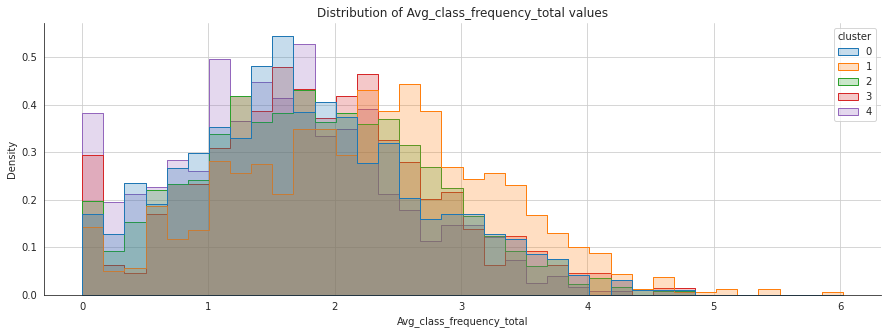

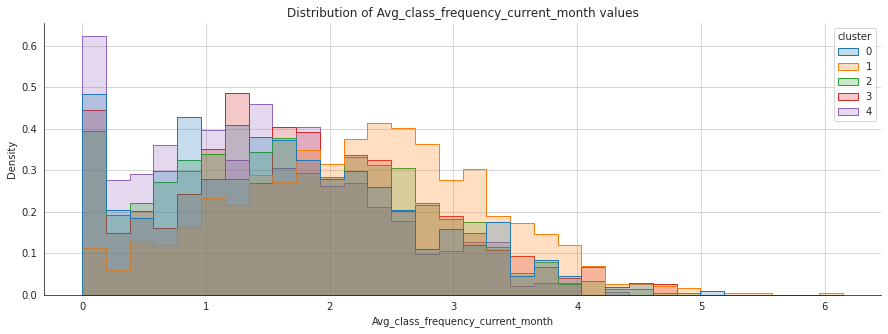

In [31]:
for col in contineous_cols:
    plt.figure(figsize = (15,5))
    sns.set_style("white")
    sns.histplot(data = df, x = col, hue = 'cluster', stat = 'density', common_norm = False, palette="tab10", element="step")
    sns.despine()
    plt.grid()
    plt.title(f'Distribution of {col} values')
    plt.show()

**Noticeable detailes of contineous features distributions:**

The only standout cluster is 1, which is the most loyal one. Customers from it tend to:
* Have the `Longest contracts`
* Be the the `oldest` ones
* Spend more money on `Additional services`
* Have the biggest time to the `End of the contract`
* Show the longest `Lifetime`
* Attend classes more `frequent`, than others

<a id="15"></a> 
* **Dataset with feature engineering**

In addition I will try alternative data preparation. For that I will keep only those columns, which have a good correlation with the target feature `Churn`. They have been visualized on the [heatmap](#corr) in the EDA stage.

In [32]:
X2 = X[['Contract_period','Age','Lifetime','Avg_class_frequency_current_month','Avg_additional_charges_total']]

In [33]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X2)

In [34]:
km = KMeans(n_clusters = 5, random_state=42)
labels = km.fit_predict(X_sc)
df['cluster'] = labels

In [35]:
round(silhouette_score(X_sc, labels),4)

0.2003

Now the identified clusters are more pronounced, as a Silhouette score is 0.2.

In [36]:
df.groupby(['cluster']).mean().sort_values(by = 'Churn')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster,,,,,,,,,,,,,,
2,0.534031,0.876963,0.507853,0.350785,0.874346,5.374346,0.473822,29.617801,150.451678,4.929319,12.408377,2.092581,2.101262,0.000000
1,0.516867,0.936145,0.714458,0.481928,0.901205,11.992771,0.542169,29.945783,158.962086,10.834940,3.689157,2.016977,2.009618,0.021687
4,0.511458,0.820833,0.419792,0.260417,0.898958,2.572917,0.403125,31.179167,96.470017,2.448958,3.230208,2.371473,2.347553,0.120833
0,0.490226,0.845113,0.446617,0.285714,0.923308,2.993985,0.386466,29.685714,274.998056,2.839098,3.190977,1.927014,1.886975,0.145865
3,0.508169,0.790198,0.395529,0.223560,0.907137,1.940671,0.321582,26.564918,105.656849,1.871023,1.611350,1.276478,0.936417,0.713672


In [37]:
df['cluster'].value_counts()

3    1163
4     960
1     830
0     665
2     382
Name: cluster, dtype: int64

Now the 2 clusters of super-loyal customers are identified: 2 (churn rate 0.0) and 1 (0.02). 2 clusters of customers, who may leave with a low probability: 4 (churn rate 0.12) and 0 (churn rate 0.15). And a cluster of customers, whose probability to leave is very high (churn rate of 0.7). These clusters will be of the most interest for the detailed overview.

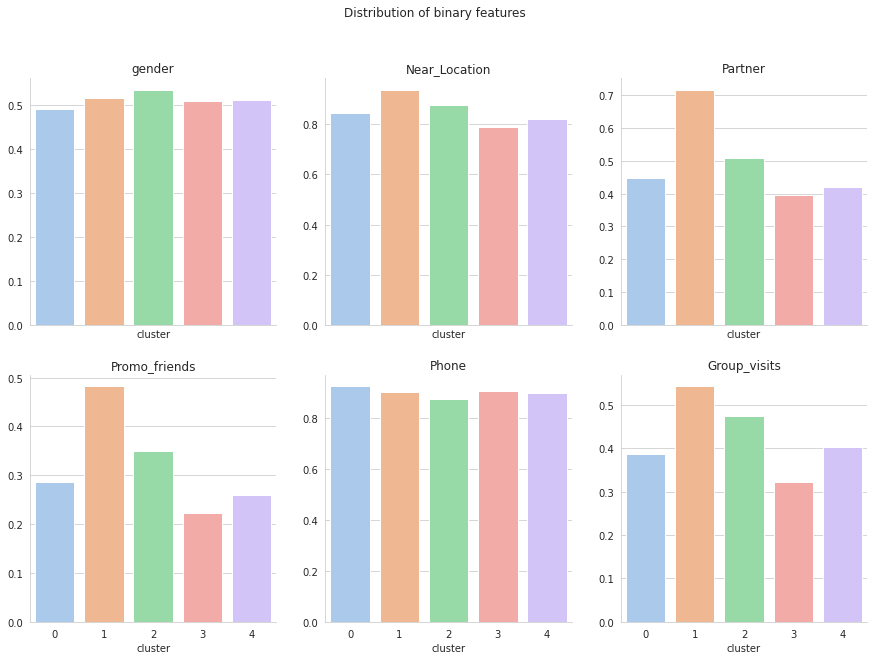

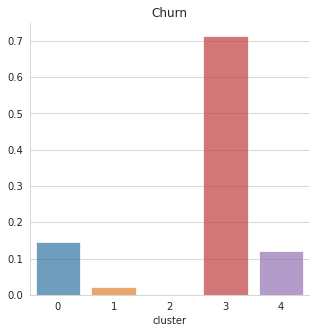

In [38]:
with sns.axes_style("whitegrid"): 
    figure, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
    k=0
    for i in range(2):
        for j in range(3):
            figure.suptitle('Distribution of binary features')
            axes[i,j].set_title(binary_cols[k])
            sns.despine()
            sns.barplot(ax=axes[i,j], data = df, x = 'cluster', y = binary_cols[k], palette = 'pastel', ci=None).set(ylabel=None)
            k+=1
    plt.figure(figsize = (5,5))
    plt.title('Churn')
    sns.barplot(data = df, x = 'cluster', y = 'Churn', alpha = .7, ci=None).set(ylabel=None)
    sns.despine()
    plt.show()

**Noticiable detailes of binary features distributions of clusters:**
* Loyal clusters 1 and 2 tend to come through the `Promo_friends` programm (more than 30% of customers)
* Loyal customers more often come through `Partner` programm (more than 50% of customers)
* They also prefer `Group` sessions (more than 40% of customers)

* The least loyal cluster 3 tend to have the lowest values of those features.

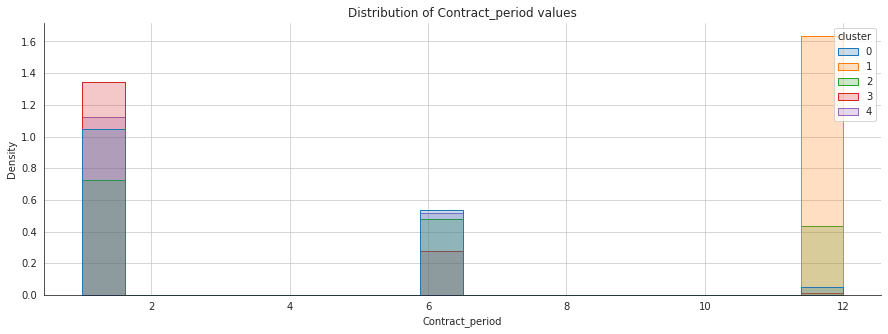

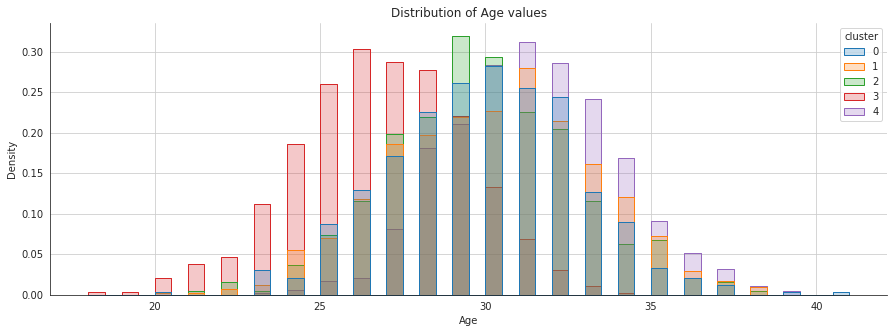

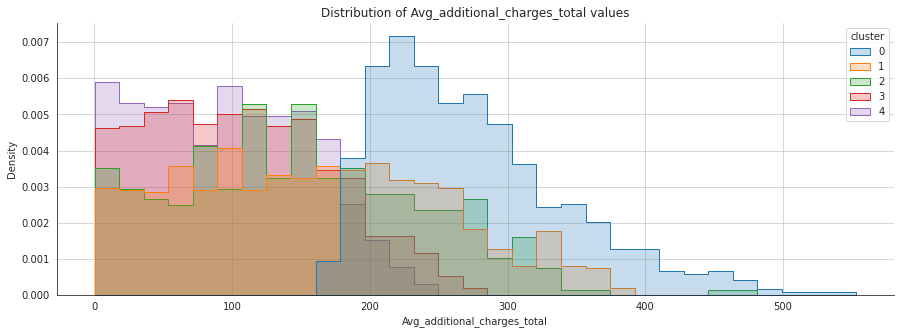

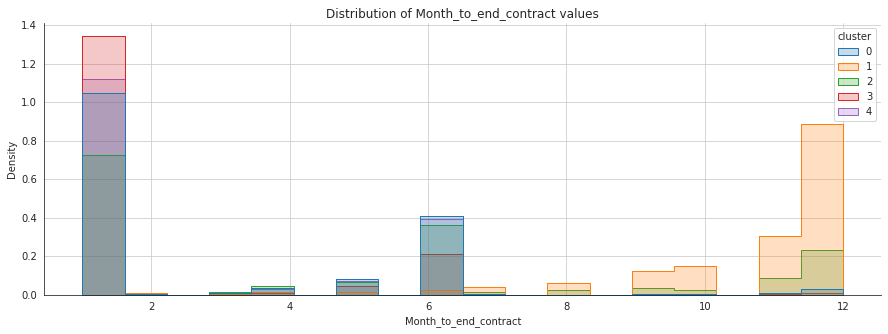

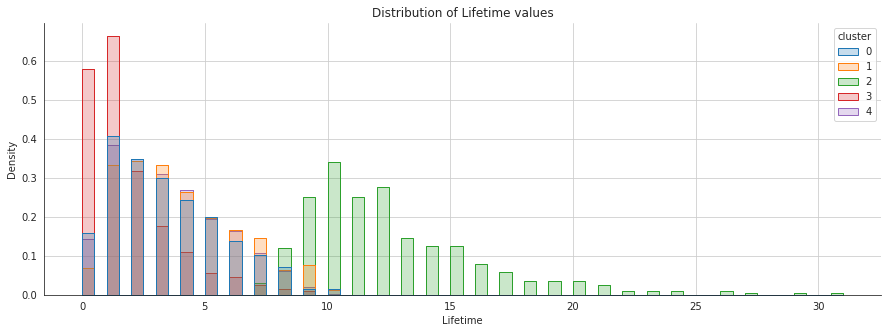

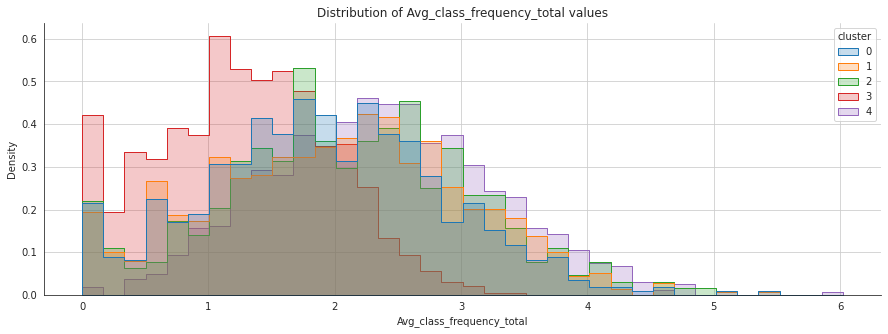

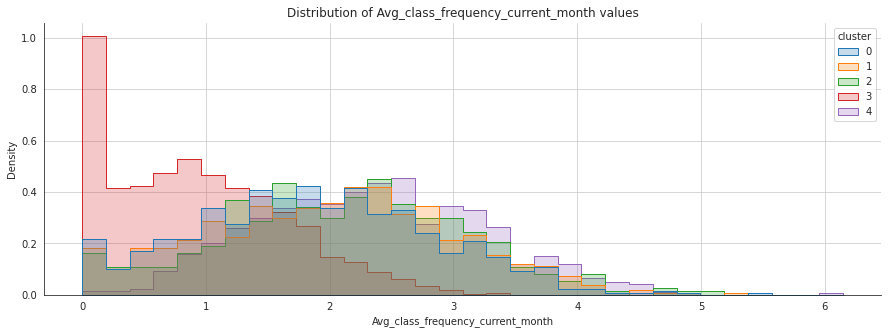

In [39]:
for col in contineous_cols:
    plt.figure(figsize = (15,5))
    sns.set_style("white")
    sns.histplot(data = df, x = col, hue = 'cluster', stat = 'density', common_norm = False, palette="tab10", element="step")
    sns.despine()
    plt.grid()
    plt.title(f'Distribution of {col} values')
    plt.show()
plt.show()

**Noticiable detailes of contineous features distributions of clusters:**
* `Contract period` - super loyal cluster 1 tend to have the longest contracts, other clusters show more or less similar values
* `Age` - The least loyal customers from the cluster 3 tend to be the yongest among other clusters
* `Additional charges` - cluster 0 (not the most loyal one, but still very loyal) tend to spend the biggest amount of money on additional services
* `Time to end contract` - super loyal cluster 1 have the longest time until the end of the contract
* `Lifetime` - super loyal cluster 2  have been attending the gym for the longest time among other clusters
* Customers from the least loyal cluster 3 have the smallest metrics of attendance: `Average total weekly frequency` and `Average frequency in the current month` 

<a id="16"></a> 
# Conclusion

Machine learning approach indeed **can** forecast if the customer may quit gym. Both **Logistic regression** and **Randon forest** models showed same *accuracy* of 90%, which is a very good result for such setting. For this specific situation the better choice seems to be a **Logistic regression**, as it identifies more customers, who are going to leave (*recall score* of 0.82 vs 0.77).

Unsupervised clusterization using **KMeans** algorythm also showed quite good results, identifying loyal clusters and clusters, where customers are prone to churn. No really homogenious groups of users have been identified (the best achieved *silhouette_score* is 0.2), but distinct populations of loyal and non-loyal customers have been found.

Both machine learning approaches revealed, that neither the user's `Gender` nor the fact, that customer has provided their `Phone` number, affect the probability for quitting gym. 

All in all, loyal customers tend to live or work `Near` the gym, come through `Partner` and `Promo_friend` programms more often, prefer longer `contracts` and `group` classes, are a bit `older`, spend more money on `Additional services` and tend to `Attend` gym 2 and more times a week (vs 1-2 for churn ones). Also, the longer the `Lifetime` and time until the `contact's end` - the better probability, that customer won't quit soon.

<a id="17"></a> 
# Recommendations

The `Partner` programm works, so it may be wise to keep expanding it. As well as `Promo_friends` programm.

It may also be a good idea to encourage customers to buy `longer contracts`, as it may stimulate them to attend the gym for a longer time. Also It may work out to start proposing purchasing the new contract 2-3 months before the current contract ends. 

The same is with `Group` classes, it should be beneficial to promote this opportunity.

There is also a correlation between user's loyalty and the amount of money, which he or she spends on `Additional` services. It is reflecting how serious about gym attendance the customer is, so, it may work out to encourage them to spend more.